# Exercise 3: error-correcting-NN 

In [ ]:
try:
    import numpy as np
    import math
    from IPython import display
    import matplotlib.pyplot as plt
    from silico_color_mixer import SilicoColorMixer
    from pathlib import Path
    import pandas as pd
    from sklearn.neural_network import MLPRegressor
except:
    !pip3 install pandas --user --upgrade
    import pandas as pd
    !pip3 install scikit-learn --user --upgrade
    from sklearn.neural_network import MLPRegressor

In [2]:
def root_sum_sqr_err(input1, input2):
    dif=np.asarray(input1)-np.asarray(input2)
    return(sum(dif**2)**0.5)

In [3]:
mixer = SilicoColorMixer(colors=['red_u', 'green_u', 'blue_t', 'yellow_u'],
                         noise=None,
                         target=None,
                         color_codes={'red_u' : [79, 21, 57],
                                     'green_u': [27, 51, 79],
                                     'blue_t' : [22, 79, 175],
                                     'yellow_u': [71, 50, 62]},)

In [4]:
# load data to dataframe
df = pd.read_csv('~/47332/data/datafile.csv', sep=';')
data = df[['Vcolors','RGB']]
# seperate independent testing set from datafram
n = 9
df11 = data.iloc[:-8-n, :]
df_indep_test = data.iloc[-8-n:-n, :]
df12 = data.iloc[-n:, :]
df1 = pd.concat([df11, df12])
print('#total:', len(df))
print('#independent:', len(df_indep_test))
print('#training+dependt',len(df)-len(df_indep_test))

#total: 95
#independent: 8
#training+dependt 87


In [7]:
# spliting remaing into training set (x) and independent testing set (1-x)
ratio = [0.1, 0.3, 0.5, 0.7, 0.9]
num = []
mean_d = []
errbar_d = []
mean_ind = []
errbar_ind = []
mean_t = []
errbar_t = []
for x in ratio:
    msk = np.random.rand(len(df1)) > x - 0.01 
    msk = np.random.rand(len(msk)) < x 
    df_train = df1[msk]
    df_dep_test = df1[~msk]
    num.append(len(df_train))
    print('#training data', len(df_train))

    # truning datafram to list
    train_list = df_train.values.tolist()
    for data in train_list:
        data[0] = eval(data[0])
        data[1] = list(eval(data[1]))
    train_x = list(np.asarray(train_list)[:,0])
    train_y = np.asarray(train_list)[:,1]

    dep_test_list = df_dep_test.values.tolist()
    for data in dep_test_list:
        data[0] = eval(data[0])
        data[1] = list(eval(data[1]))
    dep_test_x = list(np.asarray(dep_test_list)[:,0])
    dep_test_y = np.asarray(dep_test_list)[:,1]

    indep_test_list = df_indep_test.values.tolist()
    for data in indep_test_list:
        data[0] = eval(data[0])
        data[1] = list(eval(data[1]))
    indep_test_x = list(np.asarray(indep_test_list)[:,0])
    indep_test_y = np.asarray(indep_test_list)[:,1]

    # calculate the difference between Lego mixer and silico mixer
    diff_list = []
    for i in range(len(train_x)):
        output_silico = list(mixer.run_cuvette(train_x[i]))
        diff = list(np.asarray(train_y[i])-np.asarray(output_silico))
        diff_list.append(diff)  

    # train a neural network
    m_d = []
    e_d = []
    m_ind = []
    e_ind = []
    m_t = []
    e_t = []
    architech = [(5), (10), (25), (50),
                 (5, 5, 5, 3), (10, 10, 10, 3), (25, 25, 25, 3), (50, 50, 50, 3),
                 (10, 3), (10, 10, 3), (10, 10, 10, 3), (10, 10, 10, 10, 3)] 
    for i in range(len(architech)):
        mpl = MLPRegressor(solver='lbfgs', alpha=1e-5, 
                       hidden_layer_sizes=architech[i], random_state=1, max_iter=5000000000)
        mpl.fit(train_x, diff_list)

        # training error
        error_train = []
        for i in range(len(train_x)):
            nn = mpl.predict([train_x[i]])[0]
            predict_train = nn + mixer.run_cuvette(train_x[i]) # lego_predict = nn_correction + silico
            lego_train = train_y[i]                            # lego_result 
            error_train.append(root_sum_sqr_err(lego_train, predict_train))
        m_t.append(np.mean(error_train))
        e_t.append(np.std(error_train)/np.sqrt(len(train_x)))
        
        # dependent testing error
        error_dependent = []
        for i in range(len(dep_test_x)):
            nn = mpl.predict([dep_test_x[i]])[0]
            predict_dependent = nn + mixer.run_cuvette(dep_test_x[i]) # lego_predict = nn_correction + silico
            lego_dependent = dep_test_y[i]                            # lego_result 
            error_dependent.append(root_sum_sqr_err(lego_dependent, predict_dependent))
        m_d.append(np.mean(error_dependent))
        e_d.append(np.std(error_dependent)/np.sqrt(len(dep_test_x)))

        # independent testing error
        error_independent = []
        for i in range(len(indep_test_x)):
            nn = mpl.predict([indep_test_x[i]])[0]
            predict_independent = nn + mixer.run_cuvette(indep_test_x[i]) # lego_predict = nn_correction + silico
            lego_independent = indep_test_y[i]                            # lego_result 
            error_independent.append(root_sum_sqr_err(lego_independent, predict_independent))
        m_ind.append(np.mean(error_independent))
        e_ind.append(np.std(error_independent)/np.sqrt(len(indep_test_x)))
    mean_d.append(m_d)
    errbar_d.append(e_d)
    mean_ind.append(m_ind)
    errbar_ind.append(e_ind)
    mean_t.append(m_t)
    errbar_t.append(e_t)

#training data 7
#training data 24
#training data 42
#training data 61
#training data 80


In [8]:
# Load data to dataframe (dependent teeseting set)
dep = {str(num[0])+'-mean':mean_d[0], 
       str(num[1])+'-mean':mean_d[1], 
       str(num[2])+'-mean':mean_d[2],
       str(num[3])+'-mean':mean_d[3],
       str(num[4])+'-mean':mean_d[4],
       str(num[0])+'-err':errbar_d[0], 
       str(num[1])+'-err':errbar_d[1],
       str(num[2])+'-err':errbar_d[2],
       str(num[3])+'-err':errbar_d[3],
       str(num[4])+'-err':errbar_d[4]}
df_NN_dep = pd.DataFrame(dep)
#print(df_NN_dep)

# Load data to dataframe (independent teeseting set)
ind = {str(num[0])+'-mean':mean_ind[0], 
       str(num[1])+'-mean':mean_ind[1], 
       str(num[2])+'-mean':mean_ind[2],
       str(num[3])+'-mean':mean_ind[3],
       str(num[4])+'-mean':mean_ind[4],
       str(num[0])+'-err':errbar_ind[0], 
       str(num[1])+'-err':errbar_ind[1], 
       str(num[2])+'-err':errbar_ind[2],
       str(num[3])+'-err':errbar_ind[3],
       str(num[4])+'-err':errbar_ind[4]}
df_NN_indep = pd.DataFrame(ind)
#print(df_NN_indep)

# Load data to dataframe (independent teeseting set)
t = {str(num[0])+'-mean':mean_t[0], 
     str(num[1])+'-mean':mean_t[1], 
     str(num[2])+'-mean':mean_t[2],
     str(num[3])+'-mean':mean_t[3],
     str(num[4])+'-mean':mean_t[4],
     str(num[0])+'-err':errbar_t[0], 
     str(num[1])+'-err':errbar_t[1], 
     str(num[2])+'-err':errbar_t[2],
     str(num[3])+'-err':errbar_t[3],
     str(num[4])+'-err':errbar_t[4]}
df_NN_t = pd.DataFrame(t)
#print(df_NN_t)

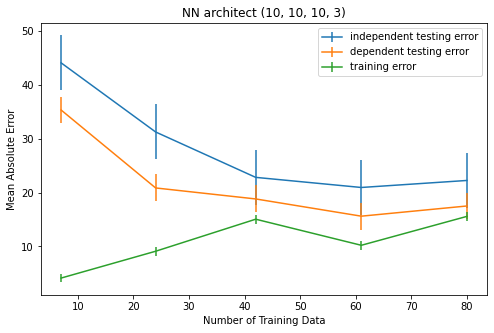

In [9]:
# plot
import numpy as np
import matplotlib.pyplot as plt

y_d_value = []
y_d_err = []
dp1 = df_NN_dep.T
for i in range(len(architech)):
    tmp = dp1[dp1.columns[i]].values.tolist()
    y_d_value.append(tmp[0:len(num)])
    y_d_err.append(tmp[-len(num)])
    
y_ind_value = []
y_ind_err = []
dp2 = df_NN_indep.T
for i in range(len(architech)):
    tmp = dp2[dp2.columns[i]].values.tolist()
    y_ind_value.append(tmp[0:len(num)])
    y_ind_err.append(tmp[-len(num)])
    
y_t_value = []
y_t_err = []
dp3 = df_NN_t.T
for i in range(len(architech)):
    tmp = dp3[dp3.columns[i]].values.tolist()
    y_t_value.append(tmp[0:len(num)])
    y_t_err.append(tmp[-len(num)])
    
i = 10
plt.figure(figsize=(8,5))
plt.errorbar(num, y_ind_value[i], yerr = y_ind_err[i], label='independent testing error')
plt.errorbar(num, y_d_value[i], yerr = y_d_err[i], label='dependent testing error')
plt.errorbar(num, y_t_value[i], yerr = y_t_err[i], label='training error')
plt.legend(loc='upper right')
plt.title('NN architect %s'%str(architech[i]))
plt.ylabel('Mean Absolute Error')
plt.xlabel('Number of Training Data')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('NN_10-10-10-3-data-report.png', dpi=300)
plt.show()

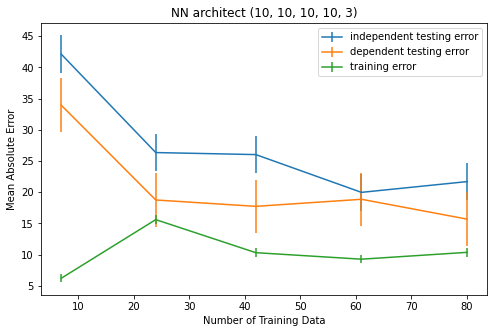

In [10]:
# plot
import numpy as np
import matplotlib.pyplot as plt

y_d_value = []
y_d_err = []
dp1 = df_NN_dep.T
for i in range(len(architech)):
    tmp = dp1[dp1.columns[i]].values.tolist()
    y_d_value.append(tmp[0:len(num)])
    y_d_err.append(tmp[-len(num)])
    
y_ind_value = []
y_ind_err = []
dp2 = df_NN_indep.T
for i in range(len(architech)):
    tmp = dp2[dp2.columns[i]].values.tolist()
    y_ind_value.append(tmp[0:len(num)])
    y_ind_err.append(tmp[-len(num)])
    
y_t_value = []
y_t_err = []
dp3 = df_NN_t.T
for i in range(len(architech)):
    tmp = dp3[dp3.columns[i]].values.tolist()
    y_t_value.append(tmp[0:len(num)])
    y_t_err.append(tmp[-len(num)])

i = 11
plt.figure(figsize=(8,5))
plt.errorbar(num, y_ind_value[i], yerr = y_ind_err[i], label='independent testing error')
plt.errorbar(num, y_d_value[i], yerr = y_d_err[i], label='dependent testing error')
plt.errorbar(num, y_t_value[i], yerr = y_t_err[i], label='training error')
plt.legend(loc='upper right')
plt.title('NN architect %s'%str(architech[i]))
plt.ylabel('Mean Absolute Error')
plt.xlabel('Number of Training Data')
plt.savefig('NN_10-10-10-10-3-data-reprt.png', dpi=300)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

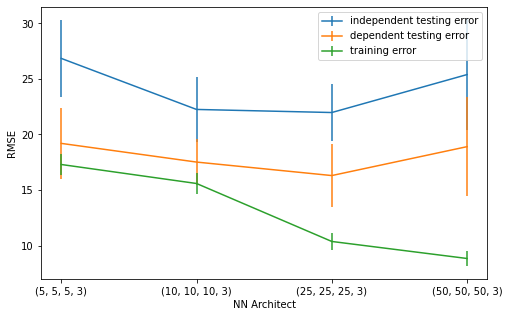

In [11]:
# plot
import numpy as np
import matplotlib.pyplot as plt

x = [str(architech[4]), str(architech[5]), str(architech[6]), str(architech[7])]

dp4 = df_NN_dep
temp1 = dp4[dp4.columns[4]].values.tolist()
temp2 = dp4[dp4.columns[9]].values.tolist()
mean_d = [temp1[4], temp1[5], temp1[6], temp1[7]]
err_d = [temp2[4], temp2[5], temp2[6], temp2[7]]
    
dp5 = df_NN_indep
temp1 = dp5[dp5.columns[4]].values.tolist()
temp2 = dp5[dp5.columns[9]].values.tolist()
mean_ind = [temp1[4], temp1[5], temp1[6], temp1[7]]
err_ind = [temp2[4], temp2[5], temp2[6], temp2[7]]

dp6 = df_NN_t
temp1 = dp6[dp6.columns[4]].values.tolist()
temp2 = dp6[dp6.columns[9]].values.tolist()
mean_t = [temp1[4], temp1[5], temp1[6], temp1[7]]
err_t = [temp2[4], temp2[5], temp2[6], temp2[7]]

plt.figure(figsize=(8,5))
plt.errorbar(x, mean_ind, yerr = err_ind, label='independent testing error')
plt.errorbar(x, mean_d, yerr = err_d, label='dependent testing error')
plt.errorbar(x, mean_t, yerr = err_t, label='training error')
plt.legend(loc='upper right')
plt.ylabel('RMSE')
plt.xlabel('NN Architect')
plt.savefig('NN_node-report.png', dpi=300)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

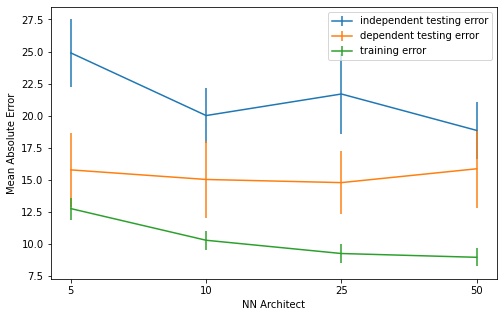

In [12]:
# plot
import numpy as np
import matplotlib.pyplot as plt

x = [str(architech[0]), str(architech[1]), str(architech[2]), str(architech[3])]

dp4 = df_NN_dep
temp1 = dp4[dp4.columns[4]].values.tolist()
temp2 = dp4[dp4.columns[9]].values.tolist()
mean_d = [temp1[0], temp1[1], temp1[2], temp1[3]]
err_d = [temp2[0], temp2[1], temp2[2], temp2[3]]
    
dp5 = df_NN_indep
temp1 = dp5[dp5.columns[4]].values.tolist()
temp2 = dp5[dp5.columns[9]].values.tolist()
mean_ind = [temp1[0], temp1[1], temp1[2], temp1[3]]
err_ind = [temp2[0], temp2[1], temp2[2], temp2[3]]

dp6 = df_NN_t
temp1 = dp6[dp6.columns[4]].values.tolist()
temp2 = dp6[dp6.columns[9]].values.tolist()
mean_t = [temp1[0], temp1[1], temp1[2], temp1[3]]
err_t = [temp2[0], temp2[1], temp2[2], temp2[3]]

plt.figure(figsize=(8,5))
plt.errorbar(x, mean_ind, yerr = err_ind, label='independent testing error')
plt.errorbar(x, mean_d, yerr = err_d, label='dependent testing error')
plt.errorbar(x, mean_t, yerr = err_t, label='training error')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.xlabel('NN Architect')
#plt.savefig('NN_node2.png', dpi=300)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

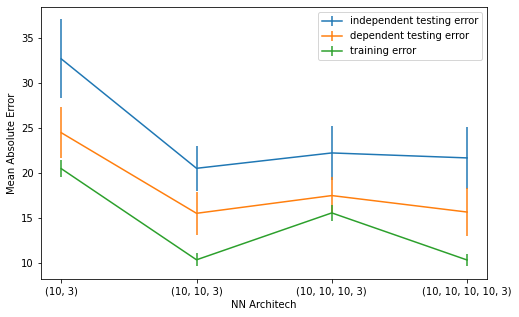

In [13]:
# plot
import numpy as np
import matplotlib.pyplot as plt

x = [str(architech[8]), str(architech[9]), str(architech[10]), str(architech[11])]

dp4 = df_NN_dep
temp1 = dp4[dp4.columns[4]].values.tolist()
temp2 = dp4[dp4.columns[9]].values.tolist()
mean_d = [temp1[8], temp1[9], temp1[10], temp1[11]]
err_d = [temp2[8], temp2[9], temp2[10], temp2[11]]
    
dp5 = df_NN_indep
temp1 = dp5[dp5.columns[4]].values.tolist()
temp2 = dp5[dp5.columns[9]].values.tolist()
mean_ind = [temp1[8], temp1[9], temp1[10], temp1[11]]
err_ind = [temp2[8], temp2[9], temp2[10], temp2[11]]

dp6 = df_NN_t
temp1 = dp6[dp6.columns[4]].values.tolist()
temp2 = dp6[dp6.columns[9]].values.tolist()
mean_t = [temp1[8], temp1[9], temp1[10], temp1[11]]
err_t = [temp2[8], temp2[9], temp2[10], temp2[11]]

plt.figure(figsize=(8,5))
plt.errorbar(x, mean_ind, yerr = err_ind, label='independent testing error')
plt.errorbar(x, mean_d, yerr = err_d, label='dependent testing error')
plt.errorbar(x, mean_t, yerr = err_t, label='training error')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.xlabel('NN Architech')
plt.savefig('NN_layer-report.png', dpi=300)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()